In [1]:
using Oceananigans
using Oceananigans.Models: ShallowWaterModel
using NCDatasets, Printf, CairoMakie

### Propagation of shallow water wave from initial disturbance

In [7]:
for f in [0, 1e-5, 5e-5, 5e-4]

Lx = 20e6
grid = RectilinearGrid(size = (512),
                       x = (-Lx/2, Lx/2),
                       topology = (Bounded, Flat, Flat))

gravitational_acceleration = 9.81
coriolis = FPlane(f=f)

model = ShallowWaterModel(; grid, coriolis, gravitational_acceleration,
                          timestepper = :RungeKutta3,
                          momentum_advection = WENO())

η₀ = 1. #m
x₀ = 0  #m
σ = 2e6
H = 100
hᵢ(x) = H + η₀*(x>x₀-σ/2)*(x<x₀+σ/2)*exp(-1/(1-(x/(σ/2))^2))/0.37
set!(model, h = hᵢ)


simulation = Simulation(model, Δt = 60, stop_time = 20*24*3600);

uh, vh, h = model.solution

fields_filename = joinpath(@__DIR__, string("../data/raw_simulation_output/shallow_water/shallow_water_1d_f=", coriolis.f, ".nc"))
simulation.output_writers[:fields] = NetCDFWriter(model, (; uh, vh, h),
                                                        filename = fields_filename,
                                                        schedule = TimeInterval(3600),
                                                        overwrite_existing = true)


run!(simulation)

ds = NCDataset(simulation.output_writers[:fields].filepath, "r")
x = ds["x_caa"];
times = ds["time"][:]
n = Observable(1)
η = @lift ds["h"][:, $n] .- H
v = @lift (ds["vh"][:, $n] ./ ds["h"][:, $n])

fig = Figure(size = (850, 550))

axis_kwargs = (xlabel = L"$x$ [km]", ylabel = L"$\eta(x,t)$ [m]", limits=((-Lx/2*1e-3, Lx/2*1e-3),(-0.3, η₀+0.3)))
ax_h  = Axis(fig[2, 1]; axis_kwargs...)
hm_h = lines!(ax_h, x*1e-3, η, linewidth=5, color=:black)
title = @lift @sprintf("t = %.1f", times[$n])
fig[1, 1] = Label(fig, title, fontsize=16, tellwidth=false)

axis_kwargs = (xlabel = L"$x$ [km]", ylabel = L"$v(x,t)$ [m/s]", limits=((-Lx/2*1e-3, Lx/2*1e-3),(-1, 1)))
ax_v  = Axis(fig[3, 1]; axis_kwargs...)
hm_v = lines!(ax_v, x*1e-3, v, linewidth=4)

resize_to_layout!(fig)

frames = 1:length(times)
record(fig, string("../movies/Lecture16_rotating_shallow_water_waves_f=", coriolis.f, ".mp4"), frames, framerate=12) do i
    n[] = i
end

close(ds)

end

┌ Warning: The ShallowWaterModel is currently unvalidated, subject to change, and should not be used for scientific research without adequate validation.
└ @ Oceananigans.Models.ShallowWaterModels ~/.julia/packages/Oceananigans/Rb6LJ/src/Models/ShallowWaterModels/shallow_water_model.jl:129
┌ Warning: Overwriting existing /Users/henrifdrake/code/ESS130/data/raw_simulation_output/shallow_water/shallow_water_1d_f=0.0.nc.
└ @ OceananigansNCDatasetsExt ~/.julia/packages/Oceananigans/Rb6LJ/ext/OceananigansNCDatasetsExt.jl:1023
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (1.151 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (888.181 ms).
[ Info: Simulation is stopping after running for 0 seconds.
[ Info: Simulation time 20 days equals or exceeds stop time 20 days.
┌ Warning: The ShallowWaterModel is currently unvalidated, subject to change, and should not be used for scientific research without adequate vali

### Poincaré dispersion relation

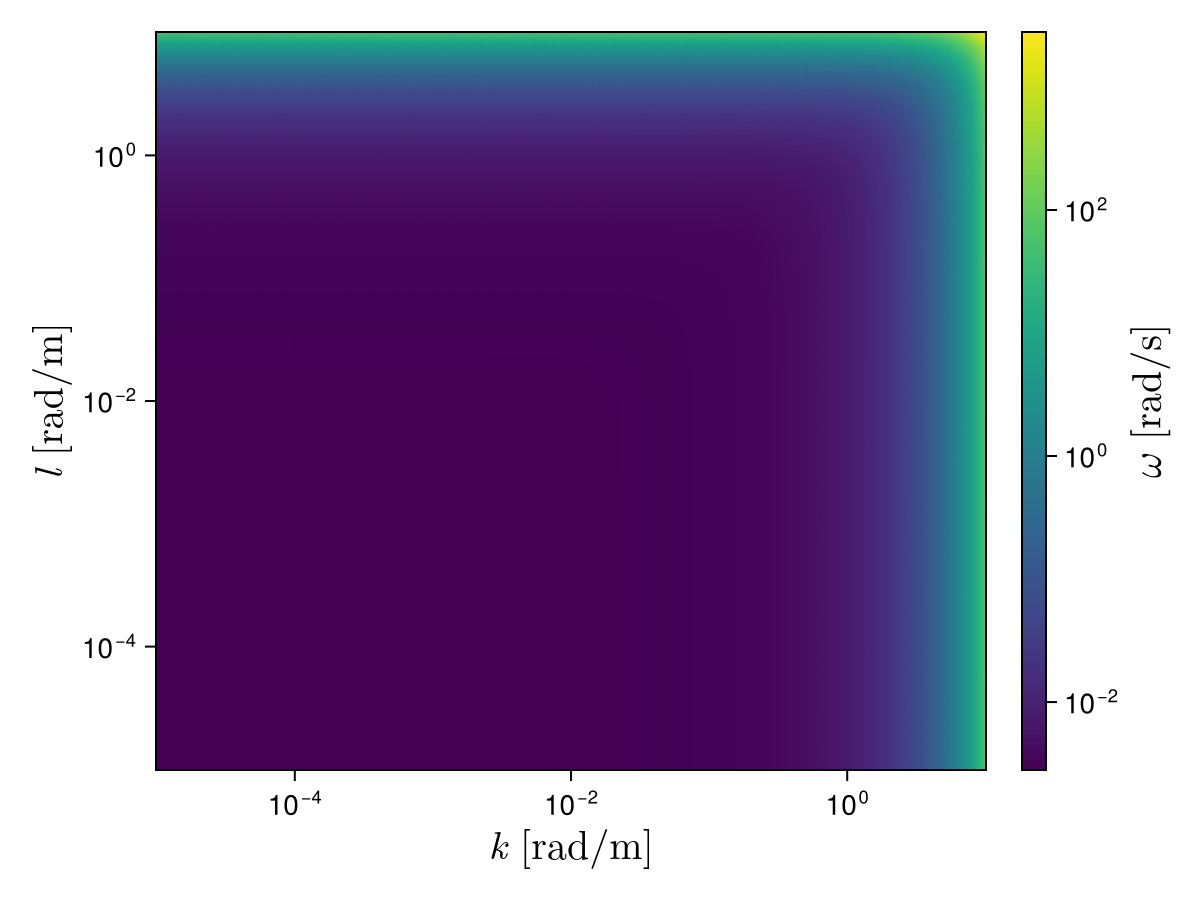

In [3]:
k = 10 .^(-5:0.01:1);
l = 10 .^(-5:0.01:1); l = reshape(l, (1, size(l)...))
ω(k, l; g=9.81, H=4000, f=5.e-5) = sqrt(f^2 + g*H*(k^2+l^2));
ω(K; g=9.81, H=4000, f=5.e-5) = sqrt(f^2 + g*H*K^2);

f = Figure()
ax = Axis(f[1,1], xscale=log10, yscale=log10, xlabel=L"$k$ [rad/m]", ylabel=L"$l$ [rad/m]", xlabelsize=20, ylabelsize=20)
hm = heatmap!(ax, k[:,1], l[1,:], ω.(k,l))
cb = Colorbar(f[1,2], hm, label=L"$\omega$ [rad/s]", labelsize=20)
cb.axis.attributes[:scale][] = log10
save("../figures/Lecture16_poincaré_dispersion_logscale.png", f)
f

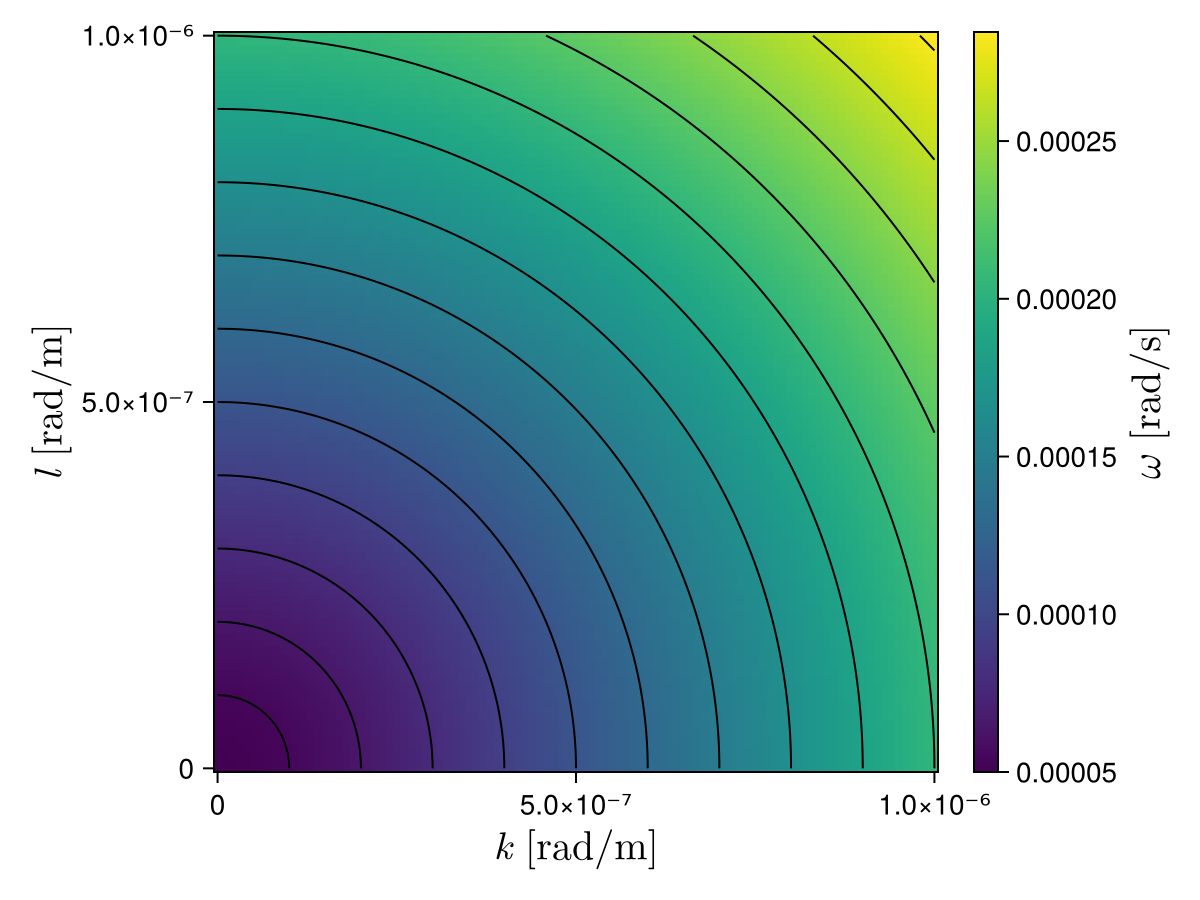

In [4]:
k = 0:1.e-8:1.e-6;
l = 0:1.e-8:1.e-6; l = reshape(l, (1, size(l)...))
ω(k, l; g=9.81, H=4000, f=5.e-5) = sqrt(f^2 + g*H*(k^2+l^2));
ω(K; g=9.81, H=4000, f=5.e-5) = sqrt(f^2 + g*H*K^2);

f = Figure()
ax = Axis(f[1,1], xlabel=L"$k$ [rad/m]", ylabel=L"$l$ [rad/m]", xlabelsize=20, ylabelsize=20)
hm = heatmap!(ax, k[:,1], l[1,:], ω.(k,l))
cb = Colorbar(f[1,2], hm, label=L"$\omega$ [rad/s]", labelsize=20)
contour!(ax, k[:,1], l[1,:], ω.(k,l), levels=ω.(0:1.e-7:2.e-6), color=:black)
save("../figures/Lecture16_poincaré_dispersion.png", f)
f

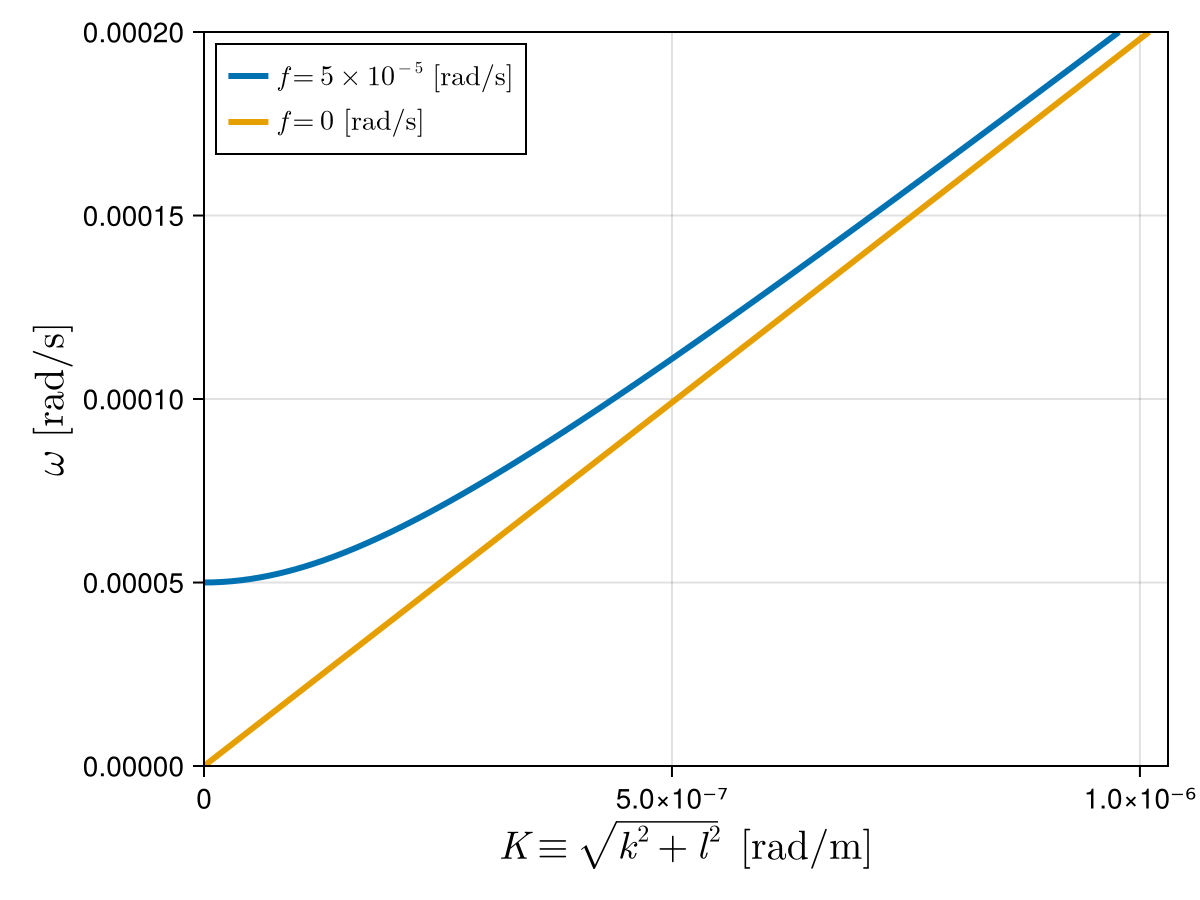

In [5]:
K = 0:1.e-8:1.2e-6;

f = Figure(figsize=(300,300))
ax = Axis(f[1,1], xlabel=L"$K \equiv \sqrt{k^2 + l^2}$ [rad/m]", ylabel=L"$\omega$ [rad/s]", limits=((0, 1.03e-6),(0, 2.e-4)), xlabelsize=20, ylabelsize=20)
lines!(ax, K, ω.(K, f=5.e-5), label=L"$f=5\times 10^{-5}$ [rad/s]", linewidth=3)
lines!(ax, K, ω.(K, f=0), label=L"$f=0$ [rad/s]", linewidth=3)
axislegend(ax, position=:lt)
save("../figures/Lecture16_poincaré_dispersion_1d.png", f)
f